In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow==2.12.0 nltk==3.8.1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


127/127 [==============================] - 2s 9ms/step


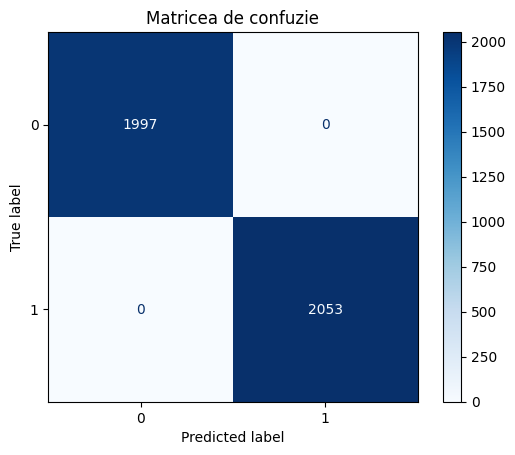

=== Raport de clasificare ===
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1997
    positive       1.00      1.00      1.00      2053

    accuracy                           1.00      4050
   macro avg       1.00      1.00      1.00      4050
weighted avg       1.00      1.00      1.00      4050


=== Metrice suplimentare ===
Acuratețe: 1.0000
Precizie: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Matthews CorrCoef: 1.0000
ROC AUC Score: 1.0


In [10]:
import pandas as pd
import json
import string
import unicodedata
import nltk
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef
)
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

# === Funcții de preprocesare ===
stop = set(stopwords.words('romanian'))

def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

def preprocess_text(text):
    text = remove_accents(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.lower().split()
    filtered_words = [word for word in words if word not in stop]
    return ' '.join(filtered_words)

# === Încarcă datele și preprocesează ===
data = pd.read_csv("/content/drive/MyDrive/house_sounds/dataset_nlp.csv")
data['text'] = data['text'].apply(preprocess_text)

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
labels = data['label'].values

# === Încărcare tokenizer ===
with open("/content/drive/MyDrive/house_sounds/new_tokenizer.json", "r") as json_file:
    tokenizer_json = json.load(json_file)
    tokenizer = tokenizer_from_json(tokenizer_json)

# === Secvențe și padding ===
sequences = tokenizer.texts_to_sequences(data['text'])
X = pad_sequences(sequences, padding='post')
y = labels

# === Împarte în train/test (30% test) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, shuffle=True)

# === Încarcă modelul ===
model = load_model("/content/drive/MyDrive/house_sounds/new_nlp_model_shieldwave")

# === Preziceri ===
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# === Evaluări ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)
try:
    auc = roc_auc_score(y_test, y_pred_prob)
except ValueError:
    auc = "ROC AUC not defined for single class"

# === Matrice de confuzie ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matricea de confuzie")
plt.show()

# === Raport de clasificare ===
print("=== Raport de clasificare ===")
target_names = label_encoder.classes_ if hasattr(label_encoder, "classes_") else ["class_0", "class_1"]
print(classification_report(y_test, y_pred, target_names=target_names))

# === Alte metrice ===
print("\n=== Metrice suplimentare ===")
print(f"Acuratețe: {accuracy:.4f}")
print(f"Precizie: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews CorrCoef: {mcc:.4f}")
print(f"ROC AUC Score: {auc}")

